In [2]:
# Python
from datetime import datetime, timedelta
import math
import time

# External
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly

import torch

# Local
from util.data import yahoo

In [3]:
# Clear cache
torch.cuda.empty_cache()

## Retrieve Data

In [4]:
# Global configurations
device = 'cuda:0'

# Data configurations
stocks = ['AAPL', 'GOOG', 'AMZN', 'FB', 'MSFT', 'NFLX', 'UBER',
          'NVDA', 'PYPL', 'NOW', 'TTWO', 'VEEV', 'V', 'IBM', 'GS',
          'DIS', 'BAC', 'MMM', 'VZ', 'JNJ', 'WMT']
interval = '1h'
end_date = datetime(2020, 4, 18)
time_range = 260
num_test_sets = 1


In [5]:
start_date = end_date - timedelta(days=time_range)
end_date_formatted = end_date.strftime("%Y-%m-%d")
start_date_formatted = start_date.strftime("%Y-%m-%d")

print(f'Retrieving from {start_date_formatted} to {end_date_formatted}.')


Retrieving from 2019-08-02 to 2020-04-18.


In [6]:
# Download stock data
raw_stock_datas = yahoo.download_stocks(stocks,start_date_formatted,end_date_formatted,interval, '../data')

../data/AAPL.pkl already downloaded, loading from file...
../data/GOOG.pkl already downloaded, loading from file...
../data/AMZN.pkl already downloaded, loading from file...
../data/FB.pkl already downloaded, loading from file...
../data/MSFT.pkl already downloaded, loading from file...
../data/NFLX.pkl already downloaded, loading from file...
../data/UBER.pkl already downloaded, loading from file...
../data/NVDA.pkl already downloaded, loading from file...
../data/PYPL.pkl already downloaded, loading from file...
../data/NOW.pkl already downloaded, loading from file...
../data/TTWO.pkl already downloaded, loading from file...
../data/VEEV.pkl already downloaded, loading from file...
../data/V.pkl already downloaded, loading from file...
../data/IBM.pkl already downloaded, loading from file...
../data/GS.pkl already downloaded, loading from file...
../data/DIS.pkl already downloaded, loading from file...
../data/BAC.pkl already downloaded, loading from file...
../data/MMM.pkl already d

In [7]:
# Explore data
print("Data has shape of %s rows by %s columns." % raw_stock_datas[0].shape)
raw_stock_datas[0].head()

Data has shape of 1247 rows by 6 columns.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-02,205.059998,206.429993,203.559998,203.912903,203.912903,11394485
2019-08-02,203.910004,203.910004,201.630005,202.949997,202.949997,7416054
2019-08-02,202.949997,204.619995,202.419998,204.339996,204.339996,4333103
2019-08-02,204.309998,204.440002,203.039993,203.289993,203.289993,3273669
2019-08-02,203.294998,204.479996,202.710007,204.070099,204.070099,2948244


## Massage Data

In [8]:
# Downselect to only the columns we need
columns = ['Open', 'High', 'Low', 'Close', 'Volume']

yahoo.downselect_columns(raw_stock_datas, columns)

In [9]:
# Verify downselection of columns
raw_stock_datas[0].columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [10]:
# Generate list of tensors from list of pandas dataframes
stock_data_tensors = yahoo.generate_tensors(raw_stock_datas)

In [11]:
# Split data into training and testing sets
training_tensors = stock_data_tensors[2:]
testing_tensors = stock_data_tensors[:2]

print(f'training_tensors contains {len(training_tensors):4} stocks')
print(f'testing_tensors  contains {len(testing_tensors):4} stocks')

training_tensors contains   19 stocks
testing_tensors  contains    2 stocks


In [12]:
# Generate chunks of tensors for training
# Note that we generate chunks AFTER splitting into training and testing sets so that these sets
# contain unique stocks
chunk_size = 40
training_tensor_chunks = yahoo.multi_generate_chunks(training_tensors, chunk_size)
testing_tensor_chunks = yahoo.multi_generate_chunks(testing_tensors, chunk_size)

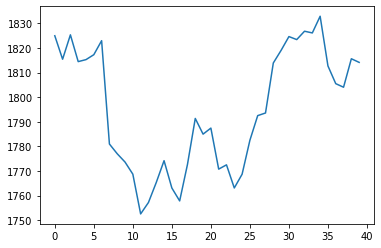

In [13]:
plt.plot(training_tensor_chunks[0][:, 3])
plt.show()

First tensor pre-normalization:
tensor([1825.0000, 1815.4600, 1825.3800, 1814.4850, 1815.3000, 1817.3000,
        1823.0000, 1780.9716, 1777.0100, 1773.6301, 1768.7069, 1752.5400,
        1757.1801, 1765.3101, 1774.1917, 1763.0823, 1757.8300, 1772.6500,
        1791.3719, 1784.9900, 1787.4500, 1770.7574, 1772.5000, 1763.1000,
        1768.6801, 1782.4998, 1792.5200, 1793.5900, 1813.9301, 1819.0800,
        1824.6699, 1823.4474, 1826.8500, 1826.1500, 1832.9399, 1812.7330,
        1805.5200, 1804.0699, 1815.6497, 1814.1744])

First tensor post-normalization:
tensor([0.7811, 0.6833, 0.7850, 0.6733, 0.6817, 0.7022, 0.7606, 0.3299, 0.2893,
        0.2547, 0.2042, 0.0385, 0.0861, 0.1694, 0.2604, 0.1466, 0.0927, 0.2446,
        0.4365, 0.3711, 0.3963, 0.2252, 0.2431, 0.1467, 0.2039, 0.3455, 0.4482,
        0.4592, 0.6676, 0.7204, 0.7777, 0.7652, 0.8000, 0.7929, 0.8624, 0.6554,
        0.5815, 0.5666, 0.6853, 0.6701])


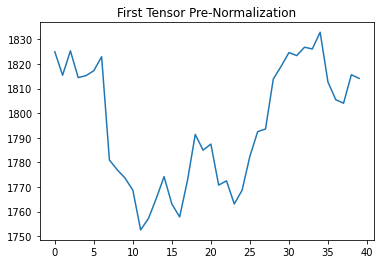

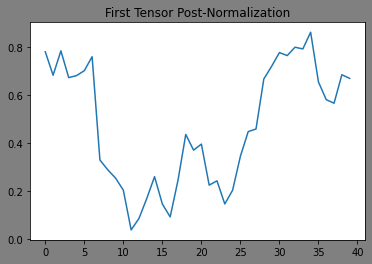

In [14]:
# Normalize each chunk in between 0 and 1

# Display before
chunk_idx = 0
ohlcv_idx = 3
print('First tensor pre-normalization:')
print(training_tensor_chunks[chunk_idx][:, ohlcv_idx])

plt.plot(training_tensor_chunks[chunk_idx][:, ohlcv_idx])
plt.title("First Tensor Pre-Normalization")
plt.rcParams['figure.facecolor'] = 'gray'

plt.show()

print()


# Normalize
yahoo.multi_normalize_tensors(training_tensor_chunks)
yahoo.multi_normalize_tensors(testing_tensor_chunks)


# Display after
print('First tensor post-normalization:')
print(training_tensor_chunks[chunk_idx][:, ohlcv_idx])

plt.plot(training_tensor_chunks[chunk_idx][:, ohlcv_idx])
plt.title("First Tensor Post-Normalization")
plt.rcParams['figure.facecolor'] = 'gray'

plt.show()

In [15]:
# Model dataset

class UnsupervisedDataset(torch.utils.data.Dataset):
    def __init__(self, data_chunks):
        self.data_chunks = data_chunks

    def __len__(self):
        return len(self.data_chunks)

    def __getitem__(self, index):
        return self.data_chunks[index]

In [16]:
# create datasets

training_dataset = UnsupervisedDataset(training_tensor_chunks)
testing_dataset = UnsupervisedDataset(testing_tensor_chunks)

In [17]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 0}

training_generator = torch.utils.data.DataLoader(training_dataset, **params)
testing_generator = torch.utils.data.DataLoader(testing_dataset, **params)


## Create Models

In [18]:
# Deduce input size from data
sample_idx = 0

chunk = training_tensor_chunks[sample_idx]
input_size = len(chunk.flatten())

In [19]:
# Configure model below:
compression_ratio = 0.05
compression_size = math.ceil(input_size * compression_ratio)

# Encoder configurations
encoder_hidden_layer_size = math.ceil((input_size + compression_size) / 2.)
encoder_num_hidden_layers = 4
encoder_dropout = 0.

# Decoder configurations
decoder_hidden_layer_size = encoder_hidden_layer_size
decoder_num_hidden_layers = encoder_num_hidden_layers
decoder_dropout = encoder_dropout

print(encoder_hidden_layer_size)

105


In [20]:
from util.torch.MLP import MLP

encoder = MLP(input_size, encoder_hidden_layer_size,
              compression_size, encoder_num_hidden_layers, encoder_dropout)
decoder = MLP(compression_size, decoder_hidden_layer_size,
              input_size, decoder_num_hidden_layers, decoder_dropout)

# Move to the desired device
encoder = encoder.to(device=device)
decoder = decoder.to(device=device)


## Execute Training

In [21]:
# Configure training Parameters
num_epochs = 100
num_training_batches = 24
learning_rate = 5e-3


In [22]:
# Set up optimizer and loss functions
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),
                             lr=learning_rate)
loss_function = torch.nn.MSELoss()


In [23]:
# Start training
print('Starting...')
for i in range(num_epochs):
    start_time = time.time()
    print(f'Processing epoch # {i} ...', flush=True)

    # Statistics to collect
    training_running_loss = 0.
    testing_running_loss = 0.

    # Train model with training batch
    encoder.train()
    decoder.train()
    for batch in training_generator:

        batch = batch.to(device=device)

        optimizer.zero_grad()

        # Pass into models
        encoded_batch = encoder(batch)
        decoded_batch = decoder(encoded_batch)

        loss = loss_function(batch, decoded_batch.view_as(batch))
        training_running_loss += loss.item()

        loss.backward()
        optimizer.step()


    # Test model with testing batch
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for batch in testing_generator:

            batch = batch.to(device=device)

            optimizer.zero_grad()

            # Pass into models
            encoded_batch = encoder(batch)
            decoded_batch = decoder(encoded_batch)

            loss = loss_function(batch, decoded_batch.view_as(batch))
            testing_running_loss += loss.item()


    # Print results
    print(f'  End epoch:  {i:3}', flush=True)
    print(f'    Time elapsed: {time.time() - start_time} sec', flush=True)
    print(f'    Training average loss: {training_running_loss / len(training_generator)}', flush=True)
    print(f'    Testing average loss:  {testing_running_loss / len(testing_generator)}', flush=True)
print("Complete.")

Starting...
Processing epoch # 0 ...
  End epoch:    0
    Time elapsed: 4.176242113113403 sec
    Training average loss: 0.04280107201387485
    Testing average loss:  0.027357444912195206
Processing epoch # 1 ...
  End epoch:    1
    Time elapsed: 1.7299959659576416 sec
    Training average loss: 0.024052299227979447
    Testing average loss:  0.02218914870172739
Processing epoch # 2 ...
  End epoch:    2
    Time elapsed: 1.5579965114593506 sec
    Training average loss: 0.022892029749022588
    Testing average loss:  0.022003901563584803
Processing epoch # 3 ...
  End epoch:    3
    Time elapsed: 1.6189987659454346 sec
    Training average loss: 0.021464105861054527
    Testing average loss:  0.019256023317575456
Processing epoch # 4 ...
  End epoch:    4
    Time elapsed: 1.7119994163513184 sec
    Training average loss: 0.02028327602893114
    Testing average loss:  0.01891141589730978
Processing epoch # 5 ...
  End epoch:    5
    Time elapsed: 1.6839966773986816 sec
    Train

In [24]:
# Clear cache
torch.cuda.empty_cache()

In [25]:
batch = list(testing_generator)[0].to(device=device)

# Run batch through model
encoder.eval()
decoder.eval()

encoded_batch = encoder(batch)
decoded_batch = decoder(encoded_batch)

# Unflatten
decoded_batch = decoded_batch.view_as(batch)

loss = loss_function(batch, decoded_batch.view_as(batch))

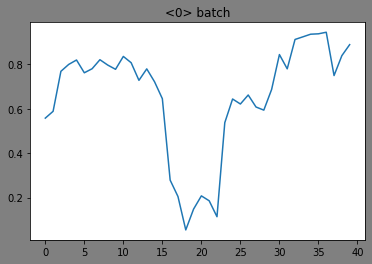

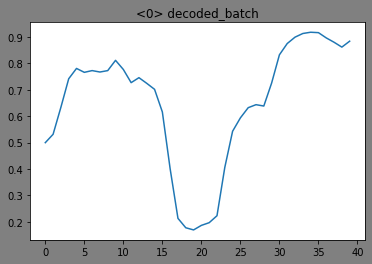

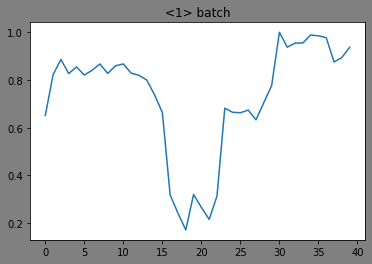

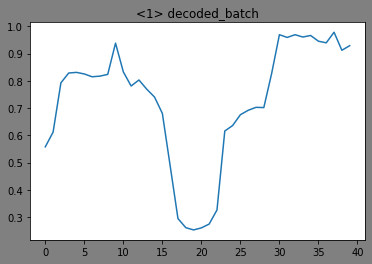

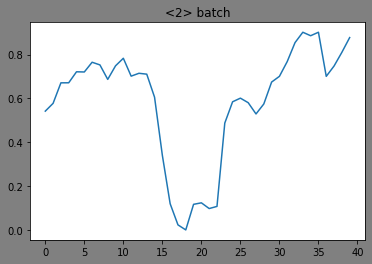

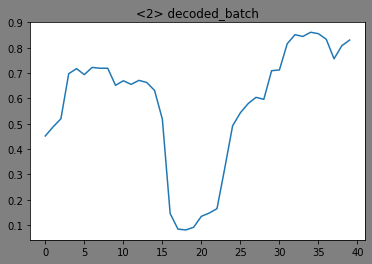

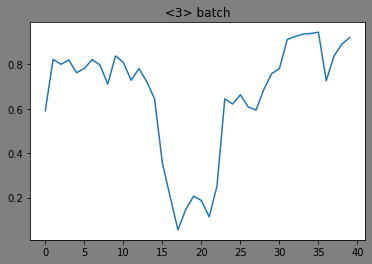

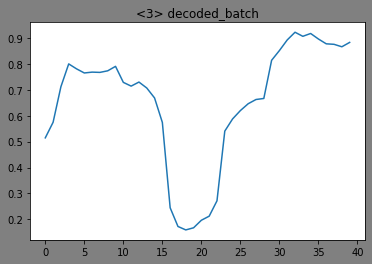

In [45]:
# Graph results

batch_idx = 20
ohlcv_idx = 4

for ohlcv_idx in range(0, 4):
    plt.plot(batch[batch_idx][:, ohlcv_idx].detach().cpu())
    plt.title(f"<{ohlcv_idx}> batch")
    plt.rcParams['figure.facecolor'] = 'gray'
    plt.show()

    plt.plot(decoded_batch[batch_idx][:, ohlcv_idx].detach().cpu())
    plt.title(f"<{ohlcv_idx}> decoded_batch")
    plt.rcParams['figure.facecolor'] = 'gray'
    plt.show()


In [46]:
print(compression_size)

10


In [47]:
# Needed to display plotly in jupyter notebook
plotly.offline.init_notebook_mode(connected=True)

fig = go.Figure(data=[go.Candlestick(
    open=batch[batch_idx][:, 0].detach().cpu(), high=batch[batch_idx][:, 1].detach().cpu(),
    low=batch[batch_idx][:, 2].detach().cpu(), close=batch[batch_idx][:, 3].detach().cpu())])

fig.update_layout(
                  title='Original Data Chunk',
                  xaxis_rangeslider_visible=True,
                  yaxis_fixedrange=False,
                 )


In [48]:
fig = go.Figure(data=[go.Candlestick(
    open=decoded_batch[batch_idx][:, 0].detach().cpu(), high=decoded_batch[batch_idx][:, 1].detach().cpu(),
    low=decoded_batch[batch_idx][:, 2].detach().cpu(), close=decoded_batch[batch_idx][:, 3].detach().cpu())])

fig.update_layout(
                  title='Encoded->Decoded Data Chunk',
                  xaxis_rangeslider_visible=True,
                  yaxis_fixedrange=False,
                 )


In [49]:
print(f'Compression: {compression_ratio * 100} %')

Compression: 5.0 %


# Conclusion
* Forcing the encoder to represent input data with only 5% of the original input size, the results above can be achieved.
* Obviously, this is lossful compression, but it seems overall direction and many defining features are preserved.